# Exercise 16 - Physics-Informed Neural Network for a Plate in Membrane Action
### Task
Implement a physics-informed neural network for a two-dimensional static plate in membrane action
1. Implement the displacement prediction function `getDisplacements`, in which a strong enforcement (`strongEnforcementx`, `strongEnforcementy`) is to be applied to the neural network output obtained with `model(input)` using the coordinates stored in `input` in a concatenated manner
2. To compute the physics-informed loss, the strains need to be computed. To this end, implement the `getStrains` function by differentiating the displacements `u`
3. Implement the physics-informed residual in `getLossTerms`
4. Run the training procedure to learn the solution to the plate in membrane problem. Can you improve the solution by adapting the hyperparameters?

### Learning goals
- Familiarize yourself with two-dimensional implementations of physics-informed neural networks

**import libraries & set seed**

In [14]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(2)

## Utilities

**gradient computation with automatic differentiation**

In [15]:
def getDerivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

**neural network**

In [16]:
class NN(torch.nn.Module):
    def __init__(
            self,
            inputDimension,
            hiddenDimensions,
            outputDimension,
            activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []

        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        u = self.model(x)
        return u

**grid creation**

In [17]:
def getGrid(Lx, Ly, Nx, Ny):
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    x, y = torch.meshgrid(x, y, indexing="ij")
    x.requires_grad = True
    y.requires_grad = True
    input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
    return x, y, input

## PINN helper functions

**displacement computation**
$$\hat{\boldsymbol{u}}=(\hat{u},\hat{v})^\intercal=F_{NN}(x)$$

In [18]:
def getDisplacements(model, input, strongEnforcementx, strongEnforcementy):
    raise NotImplementedError()  # your code goes here

**strain computation**
$$\boldsymbol{\varepsilon}=\begin{pmatrix}
\frac{\partial u}{\partial x}\\
\frac{\partial v}{\partial y}\\
\frac{1}{2}(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x})
\end{pmatrix}
$$

In [19]:
def getStrains(u, x, y, Nx, Ny):
    raise NotImplementedError()  # your code goes here

**loss term computation**

stress $$\boldsymbol{\sigma}=\boldsymbol{C}\boldsymbol{\varepsilon}$$

residual $$\boldsymbol{r}=\nabla \cdot \boldsymbol{\sigma} + \boldsymbol{p}$$

residual loss $$\mathcal{L}_R = \frac{1}{N}\sum_i^N \sum_j^2 (\hat{\boldsymbol{r}}_j)^2$$

boundary loss (only needs to consider Neumann boundary conditions when using strong enforcement of Dirichlet boundary conditions) $$\mathcal{L}_B=\frac{1}{N_{11}}\sum_i^{N_{11}} (\hat{\sigma}_{11}-\tilde{\sigma}_{11})^2 + \frac{1}{N_{22}}\sum_i^{N_{22}} (\hat{\sigma}_{22}-\tilde{\sigma}_{22})^2 + \frac{1}{N_{12}}\sum_i^{N_{12}} (\hat{\sigma}_{12}-\tilde{\sigma}_{12})^2$$

In [20]:
def getLossTerms(x, y, u, Nx, Ny, C, force):
    raise NotImplementedError()  # your code goes here
    # return differentialEquationLoss, boundaryConditionLoss

## Problem setup

**physical parameters**

In [22]:
# Problem data
Lx = 1
Ly = 1

E = 1.0
nu = 0.3
C = torch.zeros((3, 3))
C[0, 0] = 1
C[0, 1] = nu
C[1, 0] = nu
C[1, 1] = 1
C[2, 2] = 1 - nu
C *= E / (1 - nu ** 2)

# Neumann boundary condition on right edge
force = 1
# Dirichlet boundary conditions through strong enforcement
strongEnforcementx = lambda u, x, y: x * u
strongEnforcementy = lambda u, x, y: y * u

**hyperparameters**

currently Adam is selected as optimizer. By commenting the Adam block and uncommenting the LBFGS block, you can enable LBFGS as optimizer.

In [23]:
Nx = 10  # number of collocation points in x
Ny = 10  # number of collocation points in y
hiddenDimensions = [20, 20, 20]
activationFunction = torch.nn.SiLU()

epochs = 500  # number of epochs
lr = 1e-2  # learning rate
weightLrFactor = 1e1
selectOptimizer = "Adam"

**neural network & optimizer setup**

In [24]:
model = NN(2, hiddenDimensions, 2, activationFunction)
optimizer = torch.optim.Adam(model.parameters(), lr)

weights = torch.ones(2)
weights.requires_grad = True
optimizer.add_param_group({"params": weights})
optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

**training grid**

In [25]:
x, y, input = getGrid(Lx, Ly, Nx, Ny)

## Training

**cost function**
$$C=\kappa_R\mathcal{L}_R + \kappa_B\mathcal{L}_B$$

In [28]:
differentialEquationLossHistory = np.zeros(epochs)
boundaryConditionLossHistory = np.zeros(epochs)
costHistory = np.zeros(epochs)
start = time.perf_counter()
start0 = start
for epoch in range(epochs):
    optimizer.zero_grad()
    uPred = getDisplacements(model, input, strongEnforcementx, strongEnforcementy)

    lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C, force)

    cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]

    cost.backward()
    weights.grad *= -1

    optimizer.step()

    differentialEquationLossHistory[epoch] = lossTerms[0].detach()
    boundaryConditionLossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

    if epoch % 50 == 0:
        elapsedTime = (time.perf_counter() - start) / 50
        string = "Epoch: {}/{}\t\tDifferential equation cost = {:.2e}\t\tBoundary condition cost = {:.2e}\t\tTotal cost = {:.2e}\t\tElapsed time = {:2f}"
        print(
            string.format(
                epoch,
                epochs,
                differentialEquationLossHistory[epoch],
                boundaryConditionLossHistory[epoch],
                costHistory[epoch],
                elapsedTime,
            )
        )
        start = time.perf_counter()
elapsedTime = time.perf_counter() - start0
string = "Total elapsed time: {:2f}\nAverage elapsed time per epoch: {:2f}"
print(string.format(elapsedTime, elapsedTime / epochs))

Epoch: 0/500		Differential equation cost = 1.38e-03		Boundary condition cost = 4.15e-01		Total cost = 4.16e-01		Elapsed time = 0.000322
Epoch: 50/500		Differential equation cost = 1.20e-05		Boundary condition cost = 9.72e-05		Total cost = 1.09e-04		Elapsed time = 0.013279
Epoch: 100/500		Differential equation cost = 1.31e-06		Boundary condition cost = 3.15e-06		Total cost = 4.46e-06		Elapsed time = 0.013112
Epoch: 150/500		Differential equation cost = 5.84e-07		Boundary condition cost = 1.14e-06		Total cost = 1.73e-06		Elapsed time = 0.014527
Epoch: 200/500		Differential equation cost = 3.31e-07		Boundary condition cost = 5.66e-07		Total cost = 8.96e-07		Elapsed time = 0.014688
Epoch: 250/500		Differential equation cost = 2.10e-07		Boundary condition cost = 2.97e-07		Total cost = 5.08e-07		Elapsed time = 0.018278
Epoch: 300/500		Differential equation cost = 1.53e-07		Boundary condition cost = 1.77e-07		Total cost = 3.30e-07		Elapsed time = 0.018655
Epoch: 350/500		Differential equation

## Post-processing

**training history**

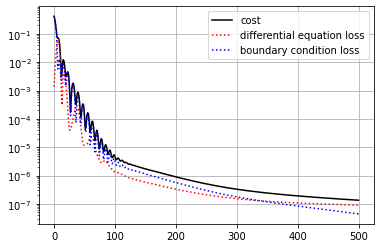

In [29]:
fig, ax = plt.subplots()
ax.plot(costHistory, "k", label="cost")
ax.plot(differentialEquationLossHistory, "r:", label="differential equation loss")
ax.plot(boundaryConditionLossHistory, "b:", label="boundary condition loss")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

**displacement prediction**

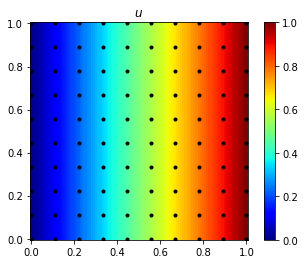

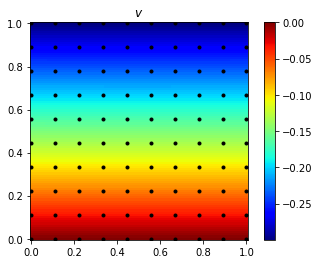

In [30]:
Nx_ = 100
Ny_ = 100
x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)

upred_ = getDisplacements(model, input_, strongEnforcementx, strongEnforcementy)
strain_ = getStrains(upred_, x_, y_, Nx_, Ny_)

fig, ax = plt.subplots()
cp = ax.pcolormesh(
    x_.detach(), y_.detach(), upred_[:, 0].reshape(Nx_, Ny_).detach(), cmap=plt.cm.jet
)
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u$")
plt.show()

fig, ax = plt.subplots()
cp = ax.pcolormesh(
    x_.detach(), y_.detach(), upred_[:, 1].reshape(Nx_, Ny_).detach(), cmap=plt.cm.jet
)
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$v$")
plt.show()